### Import packages

In [1]:
import torch
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
from datasets import Dataset
import wandb
from transformers import AutoTokenizer
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, f1_score

2025-05-03 16:03:23.671804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746288203.889081      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746288203.957571      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Load dataset

In [2]:
data = pd.read_csv('/kaggle/input/ag-news-classification-dataset/train.csv')
test_data = pd.read_csv('/kaggle/input/ag-news-classification-dataset/test.csv')
data.head() 

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


#### some explorations

In [3]:
data.shape, test_data.shape

((120000, 3), (7600, 3))

In [4]:
data['Class Index'].unique(), test_data['Class Index'].unique()

(array([3, 4, 2, 1]), array([3, 4, 2, 1]))

In [5]:
data['Class Index'] = data['Class Index']-1
test_data['Class Index'] = test_data['Class Index']-1

In [6]:
test = test_data.copy()

In [7]:
data['Class Index'].unique(), test['Class Index'].unique()

(array([2, 3, 1, 0]), array([2, 3, 1, 0]))

### AG News Labels:
### 0: World
### 1: Sports
### 2: Business
### 3: Sci/Tech


In [8]:
data['Class Index'].value_counts()

Class Index
2    30000
3    30000
1    30000
0    30000
Name: count, dtype: int64

In [9]:
test['Class Index'].value_counts()

Class Index
2    1900
3    1900
1    1900
0    1900
Name: count, dtype: int64

In [10]:
data.isnull().sum()

Class Index    0
Title          0
Description    0
dtype: int64

In [11]:
data['Description'][2]

'Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.'

In [12]:
data['Description'][3]

'Reuters - Authorities have halted oil export\\flows from the main pipeline in southern Iraq after\\intelligence showed a rebel militia could strike\\infrastructure, an oil official said on Saturday.'

In [13]:
slash = 0
slash_n = 0
douple_space = 0
for text in data['Description']:
    if '\\' in text:
        slash+=1
    if '\n'in text:
        slash_n+=1
    if r'\s+' in text:
        douple_space+=1

print('\\ in ',slash, 'samples')
print('\\n in ',slash_n, 'samples')
print('douple space in ',douple_space, 'samples')


\ in  12522 samples
\n in  0 samples
douple space in  0 samples


### Data preprocessing

In [14]:
# Concatenate Title + Description
data['text'] = data['Title'] + " " + data['Description']
test['text'] = test['Title'] + " " + test['Description']

In [15]:
data = data.drop(columns=['Title', 'Description'])
test = test.drop(columns=['Title', 'Description'])

In [16]:
data.head()

,Class Index,text
0,2,Wall St. Bears Claw Back Into the Black (Reute...
1,2,Carlyle Looks Toward Commercial Aerospace (Reu...
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,2,Iraq Halts Oil Exports from Main Southern Pipe...
4,2,"Oil prices soar to all-time record, posing new..."


In [17]:
def clean(text):
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    return text

In [18]:
data['text'] = data['text'].apply(lambda x: clean(x))
test['text'] = test['text'].apply(lambda x: clean(x))

data['text'][3]

'iraq halts oil exports from main southern pipeline reuters reuters authorities have halted oil export flows from the main pipeline in southern iraq after intelligence showed a rebel militia could strike infrastructure an oil official said on saturday '

In [19]:
# Convert Pandas DataFrame to HuggingFace Dataset
dataset = Dataset.from_pandas(data)
testing = Dataset.from_pandas(test)

In [20]:
# Tokenization
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def tokenization(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

encoded_dataset = dataset.map(tokenization, batched=True)
encoded_testing = testing.map(tokenization, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [21]:
# Remove old text columns, keep model inputs
encoded_dataset = encoded_dataset.rename_column('Class Index', 'labels')
encoded_testing = encoded_testing.rename_column('Class Index', 'labels')

encoded_dataset.set_format('torch')
encoded_testing.set_format('torch')

### Load model

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [23]:
# Load pre-trained DistilBERT model for classification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)
model.to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [24]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",       
    save_strategy="epoch",
    learning_rate=5e-5,             # tuning
    per_device_train_batch_size=32, # tuning 
    per_device_eval_batch_size=32,  # tuning
    num_train_epochs=10,             # tuning
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy", # eval
    save_total_limit=1,
    logging_dir='./logs',
    logging_steps=50,
    fp16=True if torch.cuda.is_available() else False
)


In [25]:
# Define evaluation metrics
def compute_metrics(pred):
    logits, labels = pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    return {"accuracy": acc, "f1": f1}

### Model training

In [26]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb key")

wandb.login(key=secret_value_0)
wandb.init(project="AG news classification")  

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gehadtahoon (gehadtahoon-benha-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Tracking run with wandb version 0.19.6
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250503_160418-qr19qbew
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run likely-eon-8
wandb: ⭐️ View project at https://wandb.ai/gehadtahoon-benha-university/AG%20news%20classification
wandb: 🚀 View run at https://wandb.ai/gehadtahoon-benha-university/AG%20news%20classification/runs/qr19qbew


In [27]:
# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset,
    eval_dataset=encoded_testing,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)
trainer.train() 

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.193500,0.195226,0.937105,0.937120
2,0.130700,0.202819,0.938421,0.938476
3,0.092900,0.217497,0.941053,0.940927
4,0.070800,0.290370,0.933289,0.933462
5,0.045000,0.328794,0.936316,0.936231


TrainOutput(global_step=18750, training_loss=0.11605275021235148, metrics={'train_runtime': 14912.4931, 'train_samples_per_second': 80.469, 'train_steps_per_second': 2.515, 'total_flos': 7.94832740352e+16, 'train_loss': 0.11605275021235148, 'epoch': 5.0})

In [28]:
# Save final model
trainer.save_model("./agnews_distilbert_model")
tokenizer.save_pretrained("./agnews_distilbert_model")


('./agnews_distilbert_model/tokenizer_config.json',
 './agnews_distilbert_model/special_tokens_map.json',
 './agnews_distilbert_model/vocab.txt',
 './agnews_distilbert_model/added_tokens.json',
 './agnews_distilbert_model/tokenizer.json')

### Evaluation

In [29]:
results = trainer.evaluate()
print("Final Evaluation Results:", results)

Final Evaluation Results: {'eval_loss': 0.21749727427959442, 'eval_accuracy': 0.9410526315789474, 'eval_f1': 0.9409271246542078, 'eval_runtime': 58.4222, 'eval_samples_per_second': 130.087, 'eval_steps_per_second': 4.074, 'epoch': 5.0}


### Visualization

In [30]:
# Training logs
training_logs = trainer.state.log_history

# Extract training loss and validation accuracy
train_loss = [log["loss"] for log in training_logs if "loss" in log]
eval_acc = [log["eval_accuracy"] for log in training_logs if "eval_accuracy" in log]

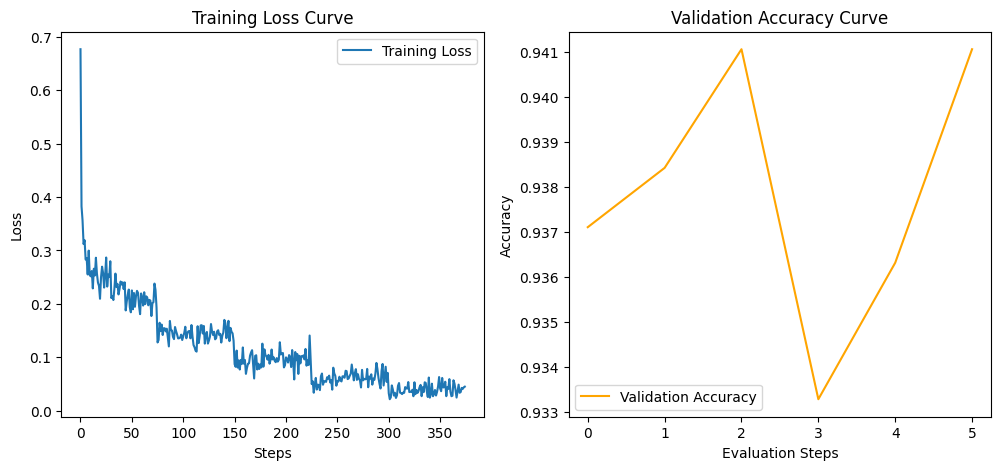

In [31]:
plt.figure(figsize=(12,5))

# Training Loss
plt.subplot(1,2,1)
plt.plot(train_loss, label="Training Loss")
plt.title("Training Loss Curve")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()

# Validation Accuracy
plt.subplot(1,2,2)
plt.plot(eval_acc, label="Validation Accuracy", color='orange')
plt.title("Validation Accuracy Curve")
plt.xlabel("Evaluation Steps")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

### Demo

In [32]:
def predict(texts):
    model.eval()
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    preds = torch.argmax(outputs.logits, dim=-1)
    return preds 

In [33]:
import random
# Test random samples
sample_indices = random.sample(range(len(test)), 5)

# Create DataFrame 
df_results = pd.DataFrame([
    {
        'sample_text': test_data['Title'][i] + " " + test_data['Description'][i],
        'actual': test_data['Class Index'][i]
    }
    for i in sample_indices
])
df_results['cleaned_text'] = df_results['sample_text'].apply(clean)

df_results['predicted'] = predict(df_results['cleaned_text'].tolist()).cpu().numpy()

print()

# Label mapping as provided
label_mapping = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}


# Define color codes
b = '\033[94m' #Blue
g = '\033[92m' #Green
r = '\033[0m' #Reset
B = '\033[1m' #Bold


for idx, row in df_results.iterrows():
    print(f"{B}Sample:{r} {row['sample_text']}")
    print(f"{B}{b}Predicted: {r}{label_mapping[row['predicted']]}  {g}{B}Actual: {r}{label_mapping[row['actual']]}\n")

print()


Sample: Photos Plus Music Equals an Expensive iPod (washingtonpost.com) washingtonpost.com - First Apple put some color on the iPod, when it offered the iPod mini in a palette of pastel hues, and now it has put some color inside it, in the form of the new iPod Photo.
Predicted: Sci/Tech  Actual: Sci/Tech

Sample: Bryant Makes First Appearance at Trial (AP) AP - NBA star Kobe Bryant arrived at his sexual assault trial Monday as attorneys in the case who spent the weekend poring over questionnaires prepared to question potential jurors individually.
Predicted: Sports  Actual: Sci/Tech

Sample: Owners Seek Best Ballpark Deal for Expos (AP) AP - Trying to get the best possible ballpark deal for the Montreal Expos, major league baseball instructed its lawyers to press ahead with negotiations involving four of the areas bidding for the team.
Predicted: Sports  Actual: Sports

Sample: Eichel Wants Strong Euro on G20 Agenda German Finance Minister Eichel called for the euro #39;s  quot;brutal